# Accuracy optimization for HR Analytics dataset 

In this document we will be analyzing the HR Analytics dataset from Kaggle

# 0. Set-up

Librabry imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import urllib
import warnings

from copy import copy

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

from collections import defaultdict

from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, \
        validation_curve, cross_validate, cross_val_predict
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

warnings.simplefilter(action='ignore')

Pipeline creation

In [2]:
def feature_engineering_pipeline(raw_data, fe_functions):
    selected_functions = []
    base_score = score_model(raw_data)
    print('Base Score: {:.4f}'.format(base_score))
    engineered_data = raw_data.copy()
    for fe_function in fe_functions:
        processed_data = globals()[fe_function](engineered_data)
        new_score = score_model(processed_data)
        print('- New Score ({}): {:.4f} '.format(fe_function, new_score), 
              end='')
        difference = (new_score-base_score)
        print('[diff: {:.4f}] '.format(difference), end='')
        if difference > -0.01:
            selected_functions.append(fe_function)
            engineered_data = processed_data.copy()
            base_score = new_score
            print('[Accepted]')
        else:
            print('[Rejected]')
    return selected_functions, engineered_data

# 1. Data loading

In [3]:
df=pd.read_csv('https://gist.githubusercontent.com/geraldwal/5bf1c1a44d0119f5b448ea8317cadd2b/raw/d999a0422f6a62b8beb36a98d6829712e53af9c1/hr_analytics_ML2', sep=',')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# 2. Data preparation

Check the types of the data. 

In [4]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

Check if there are any null values in the dataset.

In [5]:
df.isnull().values.any()

False

When we inspect the distribution of the target variable [left], we see that the dataset is *unbalanced*. 76% of the employees did not leave the company.

In [6]:
df.left.value_counts()/len(df.left)

0    0.761917
1    0.238083
Name: left, dtype: float64

With the next functions, we dummify the salary and sales categorical variables

In [7]:
def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns

def categorical_features(df):
    numerical_columns = numerical_features(df)
    return(list(set(df.columns) - set(numerical_columns)))

def onehot_encode(df):
    numericals = df.get(numerical_features(df))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df
df1 = onehot_encode(df)
df1.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_high,salary_low,...,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.38,0.53,2,157,3,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [8]:
print('Original shape of the dataset, before the onehot encoding: {}'.format(df.shape))
dataset = pd.get_dummies(df1)
print('Dataset shape after the onehot encoding: {}'.format(df1.shape))

Original shape of the dataset, before the onehot encoding: (14999, 10)
Dataset shape after the onehot encoding: (14999, 21)


We fix the variable types.

In [9]:
df1["Work_accident"] = df["Work_accident"].astype('bool')
df1["left"] = df["left"].astype('bool')
df1["promotion_last_5years"] = df["promotion_last_5years"].astype('bool')
df1["number_project"] = df["number_project"].astype('category')
df1["time_spend_company"] = df["time_spend_company"].astype('category')
df1.dtypes

satisfaction_level        float64
last_evaluation           float64
number_project           category
average_montly_hours        int64
time_spend_company       category
Work_accident                bool
left                         bool
promotion_last_5years        bool
salary_high                 uint8
salary_low                  uint8
salary_medium               uint8
sales_IT                    uint8
sales_RandD                 uint8
sales_accounting            uint8
sales_hr                    uint8
sales_management            uint8
sales_marketing             uint8
sales_product_mng           uint8
sales_sales                 uint8
sales_support               uint8
sales_technical             uint8
dtype: object

We fix the skewness.

In [10]:
def feature_skewness(df):
    numeric_dtypes = ['int64', 
                      'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features

In [11]:
def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df
fix_skewness(df1)
df1.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_high,salary_low,...,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.38,0.53,2,157,3,False,True,False,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,False,True,False,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,False,True,False,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,False,True,False,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,False,True,False,0,1,...,0,0,0,0,0,0,0,1,0,0


# Standardize average montly hours

In [12]:
#standardize average_montly_hours
# Create x, where x the 'scores' column's values as floats
x = df1[['average_montly_hours']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)
# View the dataframe
df_normalized
df1=df1.drop("average_montly_hours", axis=1)
df1=df1.join(df_normalized)
df1 = df1.rename(columns={0: 'normalized_avg_monthly_hrs'})
df1.head()

,satisfaction_level,last_evaluation,number_project,time_spend_company,Work_accident,left,promotion_last_5years,salary_high,salary_low,salary_medium,...,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,normalized_avg_monthly_hrs
0,0.38,0.53,2,3,False,True,False,0,1,0,...,0,0,0,0,0,0,1,0,0,0.285047
1,0.80,0.86,5,6,False,True,False,0,0,1,...,0,0,0,0,0,0,1,0,0,0.775701
2,0.11,0.88,7,4,False,True,False,0,0,1,...,0,0,0,0,0,0,1,0,0,0.822430
3,0.72,0.87,5,5,False,True,False,0,1,0,...,0,0,0,0,0,0,1,0,0,0.593458
4,0.37,0.52,2,3,False,True,False,0,1,0,...,0,0,0,0,0,0,1,0,0,0.294393


In [13]:
df1['normalized_avg_monthly_hrs'].describe().T

count    14999.000000
mean         0.490889
std          0.233379
min          0.000000
25%          0.280374
50%          0.485981
75%          0.696262
max          1.000000
Name: normalized_avg_monthly_hrs, dtype: float64

# 3. Exploratory Data Analysis

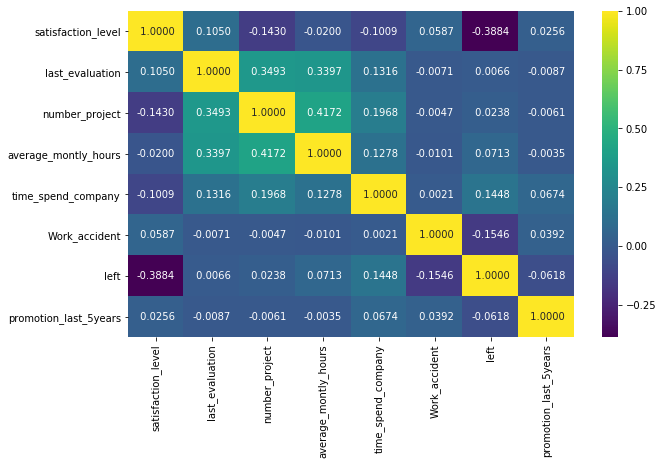

In [14]:
#Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),cbar=True,fmt =' .4f', annot=True, cmap='viridis')

Text(0.5, 1.0, 'Sales type - Left vs Did not leave')

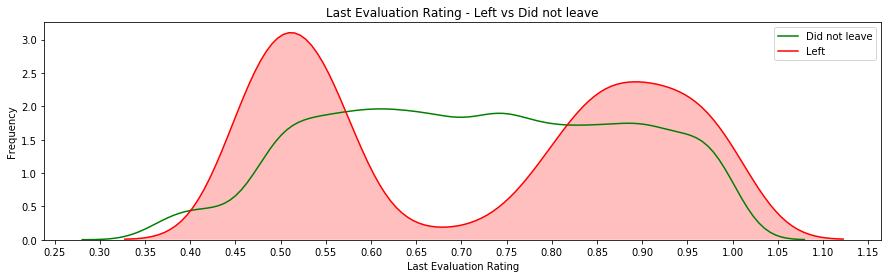

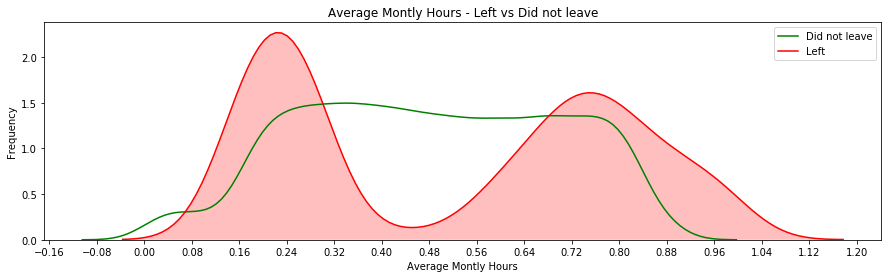

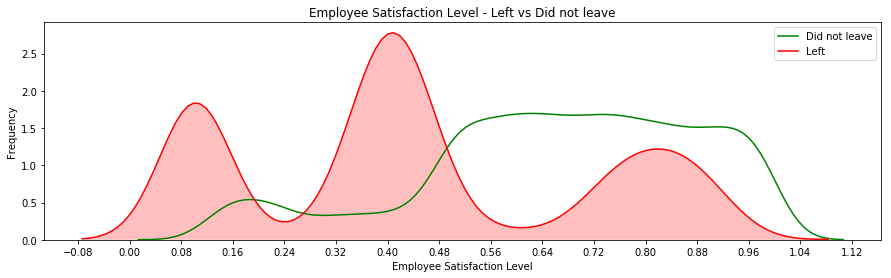

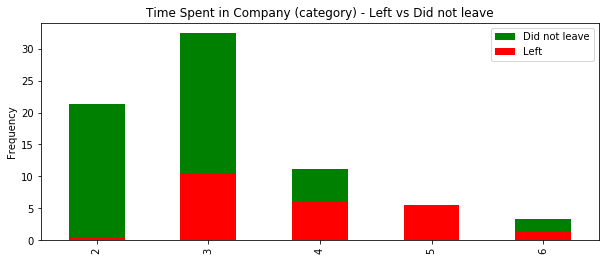

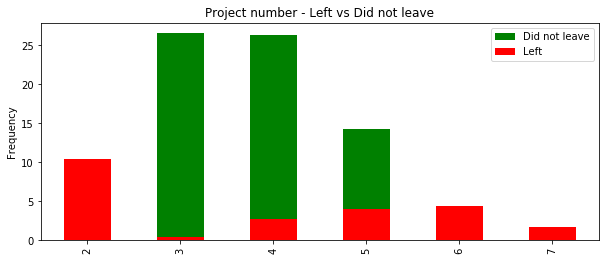

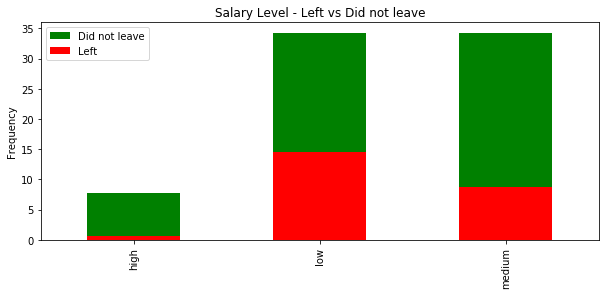

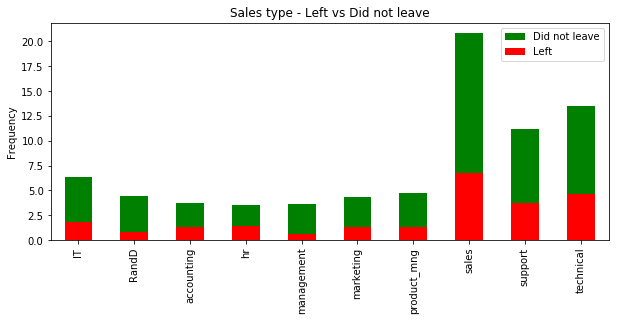

In [15]:
#Density Last Evaluation
fig=plt.figure(figsize=(15,4))
ax=sns.kdeplot(df1.loc[(df['left']==0),'last_evaluation'],color='g',shade=False,label='Did not leave')
ax=sns.kdeplot(df1.loc[(df['left']==1),'last_evaluation'],color='r',shade=True,label='Left')
ax.set(xlabel='Last Evaluation Rating',ylabel='Frequency')
plt.title('Last Evaluation Rating - Left vs Did not leave')
ax.xaxis.set_major_locator(plt.MaxNLocator(20))

#Density Average Montly Hours
fig=plt.figure(figsize=(15,4))
ax=sns.kdeplot(df1.loc[(df['left']==0),'normalized_avg_monthly_hrs'],color='g',shade=False,label='Did not leave')
ax=sns.kdeplot(df1.loc[(df['left']==1),'normalized_avg_monthly_hrs'],color='r',shade=True,label='Left')
ax.set(xlabel='Average Montly Hours',ylabel='Frequency')
plt.title('Average Montly Hours - Left vs Did not leave')
ax.xaxis.set_major_locator(plt.MaxNLocator(20))

#Density Employee Satisfaction Level
fig=plt.figure(figsize=(15,4))
ax=sns.kdeplot(df1.loc[(df['left']==0),'satisfaction_level'],color='g',shade=False,label='Did not leave')
ax=sns.kdeplot(df1.loc[(df['left']==1),'satisfaction_level'],color='r',shade=True,label='Left')
ax.set(xlabel='Employee Satisfaction Level',ylabel='Frequency')
plt.title('Employee Satisfaction Level - Left vs Did not leave')
ax.xaxis.set_major_locator(plt.MaxNLocator(20))

#Bar Time Spent in Company
plt.figure(figsize=(10,4))
ax = ((df[df.left==0].time_spend_company.value_counts().sort_index()/len(df.left))*100).plot(kind='bar',color='g')
((df[df.left==1].time_spend_company.value_counts().sort_index()/len(df.left)*100)).plot(kind='bar',color='r')
ax.legend(["Did not leave", "Left"])
ax.set(ylabel='Frequency')
plt.title('Time Spent in Company (category) - Left vs Did not leave')

#Bar Number Project
plt.figure(figsize=(10,4))
ax = ((df[df.left==0].number_project.value_counts().sort_index()/len(df.left))*100).plot(kind='bar',color='g')
((df[df.left==1].number_project.value_counts().sort_index()/len(df.left)*100)).plot(kind='bar',color='r')
ax.legend(["Did not leave", "Left"])
ax.set(ylabel='Frequency')
plt.title('Project number - Left vs Did not leave')

#Bar Chart Salary Level
plt.figure(figsize=(10,4))
ax = ((df[df.left==0].salary.value_counts().sort_index()/len(df.left))*100).plot(kind='bar',color='g')
((df[df.left==1].salary.value_counts().sort_index()/len(df.left)*100)).plot(kind='bar',color='r')
ax.legend(["Did not leave", "Left"])
ax.set(ylabel='Frequency')
plt.title('Salary Level - Left vs Did not leave')

#Bar Chart Sales Type
plt.figure(figsize=(10,4))
ax = ((df[df.left==0].sales.value_counts().sort_index()/len(df.left))*100).plot(kind='bar',color='g')
((df[df.left==1].sales.value_counts().sort_index()/len(df.left)*100)).plot(kind='bar',color='r')
ax.legend(["Did not leave", "Left"])
ax.set(ylabel='Frequency')
plt.title('Sales type - Left vs Did not leave')

Summary statistics

In [16]:
#univariate analysis
df1.describe()

,satisfaction_level,last_evaluation,salary_high,salary_low,salary_medium,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,normalized_avg_monthly_hrs
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,0.082472,0.487766,0.429762,0.081805,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345,0.490889
std,0.248631,0.171169,0.275092,0.499867,0.495059,0.274077,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317,0.233379
min,0.090000,0.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.280374
50%,0.640000,0.720000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.485981
75%,0.820000,0.870000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.696262
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
#Summary based on left
df2=df1.groupby('left')
df2.mean()

,satisfaction_level,last_evaluation,Work_accident,promotion_last_5years,salary_high,salary_low,salary_medium,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,normalized_avg_monthly_hrs
left,,,,,,,,,,,,,,,,,,
False,0.666810,0.715473,0.175009,0.026251,0.101068,0.450123,0.448810,0.083479,0.058278,0.049265,0.045852,0.047165,0.057315,0.061603,0.273539,0.146482,0.177021,0.481590
True,0.440098,0.718113,0.047326,0.005321,0.022963,0.608233,0.368804,0.076449,0.033884,0.057127,0.060207,0.025483,0.056847,0.055447,0.283954,0.155419,0.195183,0.520651


# 4. Baseline with model selection and cross validation

In [18]:
def score_logModel(data, seed=666):
    X = data.loc[:, data.columns != 'left']
    y = data.loc[:, 'left']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.20, 
                                                        random_state=seed)
    
    # Create log regression object
    logreg = LogisticRegression(solver='lbfgs')
    logreg.fit(X_train, y_train)
    
    y_pred = logreg.predict(X_test)
    return logreg.score(X_test,y_test)

def score_linModel(data, seed=666):
    X = data.loc[:, data.columns != 'left']
    y = data.loc[:, 'left']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.20, 
                                                        random_state=seed)
    
    # Create lin regression object
    linreg = linear_model.LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return linreg.score(X_test,y_test)

In [19]:
print("Logistic regression model score: {:.4f}".format(score_logModel(df1)))
print("Linear regression model score: {:.4f}".format(score_linModel(df1)))

Logistic regression model score: 0.7887
Linear regression model score: 0.2132


In [20]:
def cv_evaluate(df, splits=100):
    lr = LogisticRegression()
    kfolds = KFold(n_splits=10, shuffle=True, random_state=23)

    X = df.drop(['left'], axis=1)
    y = df.left.reset_index(drop=True)
    benchmark_model = make_pipeline(RobustScaler(), lr).fit(X=X, y=y)
    scores = cross_val_score(benchmark_model, X, y, scoring='accuracy', cv=kfolds)
    return scores[scores>=0.0]

In [21]:
accuracy_baseline = cv_evaluate(df1)
print("Min Accuracy: {:.4f}".format(np.min(accuracy_baseline)))
print("Max Accuracy: {:.4f}".format(np.max(accuracy_baseline)))
print("Mean Accuracy: {:.4f}".format(np.mean(accuracy_baseline)))

Min Accuracy: 0.7753
Max Accuracy: 0.8067
Mean Accuracy: 0.7913


# 5. Feature engineering

First, we plot the feature importance with a decision tree classifier in order to study the variable importance.

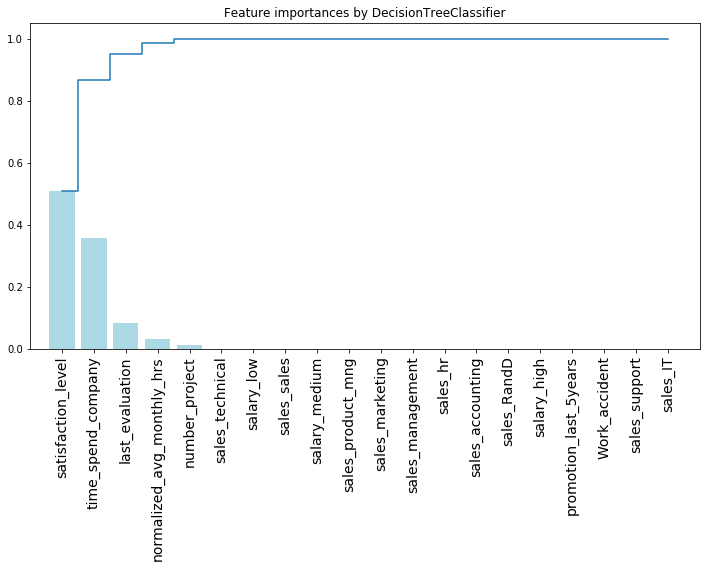

In [22]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# Create train and test splits
target_name = 'left'
X = df1.drop('left', axis=1)

y=df1[target_name]
X_train,X_test,y_train,t_test=train_test_split(X,y,test_size=0.15, random_state=123, stratify=y)

dtree = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = df1.drop(['left'],axis=1).columns

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

Next, we use binning, in order to create features that improve the accuracy prediction.

In [23]:
#satisfaction_level bins
def satisf(df):
    df_NK = df1.copy()

    bins = [0, 0.11, 0.35, 0.46, 0.72, 0.91, 1.0]
    df_NK['satisfaction_level_bin'] = pd.cut(df_NK.satisfaction_level,bins)
    
    df_NK = pd.concat([df_NK, pd.get_dummies(df_NK['satisfaction_level_bin'],prefix='sat', prefix_sep='_')], axis=1)
    df_NK.drop('satisfaction_level_bin', inplace=True, axis=1)
    df_NK.drop('satisfaction_level', inplace=True, axis=1)
    return df_NK

In [24]:
#last_evaluation bins
def eval(df):
    df_NK = df1.copy()
    bins = [0, 0.39, 0.45, 0.57, 0.65, 0.88, 0.95, 1.15]
    df_NK['last_evaluation_bin'] = pd.cut(df_NK.last_evaluation,bins)
    
    df_NK = pd.concat([df_NK, pd.get_dummies(df_NK['last_evaluation_bin'],prefix='eval', prefix_sep='_')], axis=1)
    df_NK.drop('last_evaluation_bin', inplace=True, axis=1)
    df_NK.drop('last_evaluation', inplace=True, axis=1)
    return df_NK

In [25]:
def eval_alt(df):
    df_NK = df1.copy()
    bins = [0, 0.4, 0.57, 0.81, 1.15]
    df_NK['evaluation_bin2'] = pd.cut(df_NK.last_evaluation,bins)
    
    df_NK = pd.concat([df_NK, pd.get_dummies(df_NK['evaluation_bin2'],prefix='eval2', prefix_sep='_')], axis=1)
    df_NK.drop('evaluation_bin2', inplace=True, axis=1)
    df_NK.drop('last_evaluation', inplace=True, axis=1)
    return df_NK

In [26]:
def monthly_hrs(df):
    df_NK = df1.copy()
    bins = [-0.12,0.06,0.18,0.32,0.68,0.81,1.2]
    df_NK['monthly_hrs_bin'] = pd.cut(df_NK.normalized_avg_monthly_hrs,bins)
    
    df_NK = pd.concat([df_NK, pd.get_dummies(df_NK['monthly_hrs_bin'],prefix='month_', prefix_sep='_')], axis=1)
    df_NK.drop('monthly_hrs_bin', inplace=True, axis=1)
    df_NK.drop('normalized_avg_monthly_hrs', inplace=True, axis=1)
    return df_NK

In [27]:
#binning of time spent variable categorically
def time_spentCat(df):
    df_NK = df1.copy()
    dict = {2: "low", 3 : "medium", 4 : "medium", 6 : "medium", 5: "high", 7: "very low", 8: "very low", 10: "very low"}

    df_NK['time_spend_company_bin'] = df_NK['time_spend_company'].map(dict)

    df_NK = pd.concat([df_NK, pd.get_dummies(df_NK['time_spend_company_bin'],prefix='time', prefix_sep='_')], axis=1)
    df_NK.drop('time_spend_company_bin', inplace=True, axis=1)
    df_NK.drop('time_spend_company', inplace=True, axis=1)
    return df_NK
    df_NK.head()

In [28]:
#binning of project numbers variable
def project_numbers(df):
    df_NK = df1.copy()
    dict = {2: "starter", 3: "basic", 4 : "intermediate", 5 : "advanced", 6: "specialist", 7: "executive"}

    df_NK['number_project_cat'] = df_NK['number_project'].map(dict)

    df_NK = pd.concat([df_NK, pd.get_dummies(df_NK['number_project_cat'],prefix='project', prefix_sep='_')], axis=1)
    df_NK.drop('number_project_cat', inplace=True, axis=1)
    df_NK.drop('number_project', inplace=True, axis=1)
    return df_NK

In [29]:
#binning of project numbers variableAlt
def project_numbersAlt(df):
    df_NK = df1.copy()
    dict = {3: "low", 4 : "medium", 5 : "advance",  2: "high", 6: "high", 7: "high"}

    df_NK['number_project_cat'] = df_NK['number_project'].map(dict)

    df_NK = pd.concat([df_NK, pd.get_dummies(df_NK['number_project_cat'],prefix='project2', prefix_sep='_')], axis=1)
    df_NK.drop('number_project_cat', inplace=True, axis=1)
    df_NK.drop('number_project', inplace=True, axis=1)
    return df_NK

We fix possible under representation, which we will see the effect from in the final scoring.

In [30]:
def under_represented_features(df):
    under_rep = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if ((zeros / len(df)) * 100) > 99.0:
            under_rep.append(i)
    df.drop(under_rep, axis=1, inplace=True)
    return df

# 6. Final scoring

We write the function to score the model.

In [31]:
def score_model(data, seed=666):
    X = data.loc[:, data.columns != 'left']
    y = data.loc[:, 'left']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.20, 
                                                        random_state=seed)
    
    # Create linear regression object
    regr = linear_model.LogisticRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    score= regr.score(X_test, y_test)
    return score
    #return accuracy_score(y_test, y_pred)

#from sklearn.cross_validation import train_test_split
#Xtrain, Xtest, ytrain, ytest = train_test_split(X_iris, y_iris, random_state=1)

We take the functions of features we want to evaluate that are predicted to improve our model.

In [32]:
fe_functions = ['satisf', 'eval', 'eval_alt','monthly_hrs', 'project_numbers','project_numbersAlt', 'time_spentCat', 'under_represented_features' ]
funcs, new_dataset = feature_engineering_pipeline(df1, fe_functions)

accuracy = cv_evaluate(new_dataset, splits=100)
print('Mean accuracy after CV: {:.4f} +/- {:.4f}'.format(np.mean(accuracy), np.std(accuracy)))
print('Max accuracy after CV: {:.4f}'.format(np.max(accuracy)))
#print('Accuracy in hold-out dataset: {:.3f}'.format(
 #   pipeline.score(X.test, y.test)))

Base Score: 0.7887
- New Score (satisf): 0.9083 [diff: 0.1197] [Accepted]
- New Score (eval): 0.8357 [diff: -0.0727] [Rejected]
- New Score (eval_alt): 0.8257 [diff: -0.0827] [Rejected]
- New Score (monthly_hrs): 0.8420 [diff: -0.0663] [Rejected]
- New Score (project_numbers): 0.8630 [diff: -0.0453] [Rejected]
- New Score (project_numbersAlt): 0.8513 [diff: -0.0570] [Rejected]
- New Score (time_spentCat): 0.8423 [diff: -0.0660] [Rejected]
- New Score (under_represented_features): 0.9083 [diff: 0.0000] [Accepted]
Mean accuracy after CV: 0.9127 +/- 0.0075
Max accuracy after CV: 0.9260


A problem that was not been possible to solve is that no other metrics build further on the highest score of the satisfaction level. The fact that no dependency between the features is displayed must be a mistake, made in my code.

In [33]:
fe_functions = ['satisf']
funcs, new_dataset = feature_engineering_pipeline(df1, fe_functions)

accuracy = cv_evaluate(new_dataset, splits=100)
print('Mean accuracy after CV: {:.4f} +/- {:.4f}'.format(np.mean(accuracy), np.std(accuracy)))
print('Max accuracy after CV: {:.4f}'.format(np.max(accuracy)))

Base Score: 0.7887
- New Score (satisf): 0.9083 [diff: 0.1197] [Accepted]
Mean accuracy after CV: 0.9127 +/- 0.0075
Max accuracy after CV: 0.9260
